# Project 3 - Classification
Welcome to the third project of Data 8!  You will build a classifier that guesses whether a song is hip-hop or country, using only the numbers of times words appear in the song's lyrics.  By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

#### Administrivia
##### Piazza
While collaboration is encouraged on this and other assignments, sharing answers is never okay. In particular, posting code or other assignment answers publicly on Piazza (or elsewhere) is academic dishonesty. It will result in a reduced project grade at a minimum. If you wish to ask a question and include your code or an answer to a written question, you *must* make it a private post.

##### Partners
You may complete the project with up to one partner. Partnerships are an exception to the rule against sharing answers. If you have a partner, one person in the partnership should submit your project on Gradescope and include the other partner in the submission. (Gradescope will prompt you to fill this in.)

For this project, **you can partner with anyone in the class.**

##### Due Date and Checkpoint
Part of the project will be due early.  Parts 1 and 2 of the project (out of 4) are due **Tuesday, November 22nd at 7PM**.  Unlike the final submission, this early checkpoint  will be graded for completion. It will be worth approximately 10% of the total project grade.  Simply submit your partially-completed notebook as a PDF, as you would submit any other notebook.  (See the note above on submitting with a partner.)

The entire project (parts 1, 2, 3, and 4) will be due **Tuesday, November 29th at 7PM**. (Again, see the note above on submitting with a partner.)

#### On to the project!

**Run the cell below** to prepare the automatic tests. **Passing the automatic tests does not guarantee full credit on any question.** The tests are provided to help catch some common errors, but it is your responsibility to answer the questions correctly.

In [9]:
# Run this cell to set up the notebook, but please don't change it.

import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# These lines load the tests.

# 1. The Dataset

Our dataset is a table of songs, each with a name, an artist, and a genre.  We'll be trying to predict each song's genre.

The predict a song's genre, we have some attributes: the lyrics of the song, in a certain format.  We have a list of approximately 5,000 words that might occur in a song.  For each song, our dataset tells us how frequently each of these words occur in that song.

Run the cell below to read the `lyrics` table. **It may take up to a minute to load.**

In [10]:
# Just run this cell.
lyrics = Table.read_table('lyrics.csv')

# The first 5 rows and 8 columns of the table:
lyrics.where("Title", are.equal_to("In Your Eyes"))\
      .select("Title", "Artist", "Genre", "i", "the", "like", "love")\
      .show()

Title,Artist,Genre,i,the,like,love
In Your Eyes,Alison Krauss,Country,0.107143,0,0.0119048,0.0595238


That cell prints a few columns of the row for the song "In Your Eyes".  The song contains 168 words. The word "like" appears twice:  $\frac{2}{168} \approx 0.0119$ of the words in the song. Similarly, the word "love" appears 10 times: $\frac{10}{168} \approx 0.0595$ of the words.

Our dataset doesn't contain all information about a song.  For example, it doesn't include the total number of words in each song, or information about the order of words in the song, let alone the melody, instruments, or rhythm. Nonetheless, you may find that word counts alone are sufficient to build an accurate genre classifier.

All titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [11]:
title_index = lyrics.index_by('Title')
def row_for_title(title):
    return title_index.get(title)[0]

<div class="hide">\pagebreak</div>
#### Question 1.1
Set `expected_row_sum` to the number that you expect will result from summing all proportions in each row, excluding the first three columns.

In [12]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

<div class="hide">\pagebreak</div>
You can draw the histogram below to check that the actual row sums are close to what you expect.

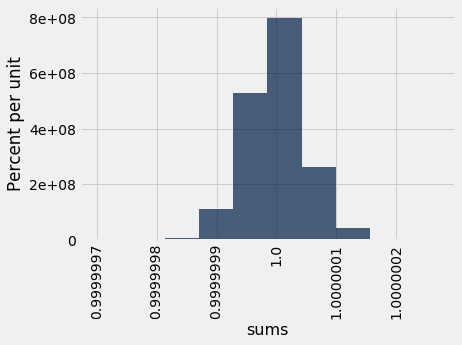

In [13]:
# Run this cell to display a histogram of the sums of proportions in each row.
# This computation might take up to a minute; you can skip it if it's too slow.
Table().with_column('sums', lyrics.drop([0, 1, 2]).apply(sum)).hist(0)

This dataset was extracted from the Million Song Dataset (http://labrosa.ee.columbia.edu/millionsong/). Specifically, we are using the complementary datasets from musiXmatch (http://labrosa.ee.columbia.edu/millionsong/musixmatch) and Last.fm (http://labrosa.ee.columbia.edu/millionsong/lastfm).

The counts of common words in the lyrics for all of these songs are provided by the musiXmatch dataset (called a bag-of-words format). Only the top 5000 most common words are represented. For each song, we divided the number of occurrences of each word by the total number of word occurrences in the lyrics of that song.

The Last.fm dataset contains multiple tags for each song in the Million Song Dataset. Some of the tags are genre-related, such as "pop", "rock", "classic", etc.  To obtain our dataset, we first extracted songs with Last.fm tags that included the words "country", or "hip" and "hop". These songs were then cross-referenced with the musiXmatch dataset, and only songs with musixMatch lyrics were placed into our dataset. Finally, inappropriate words and songs with naughty titles were removed, leaving us with 4976 words in the vocabulary and 1726 songs.

## 1.1. Word Stemming
The columns other than Title, Artist, and Genre in the `lyrics` table are all words that appear in some of the songs in our dataset.  Some of those names have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each song.  

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [15]:
# Just run this cell.
vocab_mapping = Table.read_table('mxm_reverse_mapping_safe.csv')
stemmed = np.take(lyrics.labels, np.arange(3, len(lyrics.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(900, 910))

Stem,Word
coup,coup
coupl,couple
courag,courage
cours,course
court,court
cousin,cousin
cover,cover
cow,cow
coward,coward
cowboy,cowboy


<div class="hide">\pagebreak</div>
#### Question 1.1.1
Assign `unchanged` to the **percentage** of words in `vocab_table` that are the same as their stemmed form (such as "coup" above).

*Hint:* Try to use `where`.  Start by computing an array of boolean values, one for each row in `vocab_table`, indicating whether the word in that row is equal to its stemmed form.

In [28]:
# The staff solution took 3 lines.
unchanged = 100*len(vocab_table.where('Stem',are.equal_to(vocab_table.column('Word'))).column('Stem'))/len(vocab_table.column('Stem'))
print(str(round(unchanged)) + '%')

72%


<div class="hide">\pagebreak</div>
#### Question 1.1.2
Assign `stemmed_message` to the stemmed version of the word "message".

In [35]:
# Set stemmed_message to the stemmed version of "message" (which
# should be a string).  Use vocab_table.
stemmed_message = vocab_table.where('Word',are.equal_to('message')).column('Stem')[0]
stemmed_message

'messag'

<div class="hide">\pagebreak</div>
#### Question 1.1.3
Assign `unstemmed_singl` to the word in `vocab_table` that has "singl" as its stemmed form. (*Note that multiple English words may stem to "singl", but only one example appears in `vocab_table`.*)

In [38]:
# Set unstemmed_singl to the unstemmed version of "singl" (which
# should be a string).
unstemmed_singl = vocab_table.where('Stem',are.equal_to('singl')).column('Word')[0]
unstemmed_singl

'single'

<div class="hide">\pagebreak</div>
#### Question 1.1.4
What word in `vocab_table` was shortened the most by this stemming process? Assign `most_shortened` to the word. It's an example of how heuristic stemming can collapse two unrelated words into the same stem (which is bad, but happens a lot in practice anyway).

In [55]:
# In our solution, we found it useful to first make an array
# called shortened containing the number of characters that was
# chopped off of each word in vocab_table, but you don't have
# to do that.

shortened = vocab_table.column('Stem').apply(len)
shortened
# most_shortened = ...

# # This will display your answer and its shortened form.
# vocab_table.where('Word', most_shortened)

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

## 1.2. Splitting the dataset
We're going to use our `lyrics` dataset for two purposes.

1. First, we want to *train* song genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no songs that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [4]:
# Here we have defined the proportion of our data
# that we want to designate for training as 11/16ths
# of our total dataset.  5/16ths of the data is
# reserved for testing.

training_proportion = 11/16

num_songs = lyrics.num_rows
num_train = int(num_songs * training_proportion)
num_valid = num_songs - num_train

train_lyrics = lyrics.take(np.arange(num_train))
test_lyrics = lyrics.take(np.arange(num_train, num_songs))

print("Training: ",   train_lyrics.num_rows, ";",
      "Test: ",       test_lyrics.num_rows)

<div class="hide">\pagebreak</div>
#### Question 1.2.1
Draw a horizontal bar chart with two bars that show the proportion of Country songs in each dataset.  Complete the function `country_proportion` first; it should help you create the bar chart.

In [ ]:
def country_proportion(table):
    """Return the proportion of songs in a table that have the Country genre."""
    return ...

# The staff solution took 4 lines.  Start by creating a table.
...

# 2. K-Nearest Neighbors - a Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples.

A feature we have about each song is *the proportion of times a particular word appears in the lyrics*, and the categories are two music genres: hip-hop and country.  The algorithm requires many previously seen examples for which both the features and categories are known: that's the `train_lyrics` table.

We're going to visualize the algorithm, instead of just describing it. To get started, let's pick colors for the genres.

In [5]:
# Just run this cell to define genre_colors.

def genre_color(genre):
    """Assign a color to each genre."""
    if genre == 'Country':
        return 'gold'
    elif genre == 'Hip-hop':
        return 'blue'
    else:
        return 'green'

## 2.1. Classifying a  song

In k-NN, we classify a song by finding the `k` songs in the *training set* that are most similar according to the features we choose. We call those songs with similar features the "neighbors".  The k-NN algorithm assigns the song to the most common category among its `k` neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each song.  The features we will use are the proportions of the words "like" and "love" in the lyrics.  Taking the song "In Your Eyes" (in the test set), 0.0119 of its words are "like" and 0.0595 are "love". This song appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *dissimilarity*, or *distance* between two songs is the straight-line distance between them when we plot their features in a scatter diagram. This distance is called the Euclidean ("yoo-KLID-ee-un") distance.  

For example, in the song *Insane in the Brain* (in the training set), 0.0203 of all the words in the song are "like" and 0 are "love".  Its distance from *In Your Eyes* on this 2-word feature set is $\sqrt{(0.0119 - 0.0203)^2 + (0.0595 - 0)^2} \approx 0.06$.  (If we included more or different features, the distance could be different.)

A third song, *Sangria Wine* (in the training set), is 0.0044 "like" and 0.0925 "love".

The function below creates a plot to display the "like" and "love" features of a test song and some training songs. As you can see in the result, *In Your Eyes* is more similar to *Sangria Wine* than to *Insane in the Brain*.

In [ ]:
# Just run this cell.

def plot_with_two_features(test_song, training_songs, x_feature, y_feature):
    """Plot a test song and training songs using two features."""
    test_row = row_for_title(test_song)
    distances = Table().with_columns(
            x_feature, make_array(test_row.item(x_feature)),
            y_feature, make_array(test_row.item(y_feature)),
            'Color',   make_array(genre_color('Unknown')),
            'Title',   make_array(test_song)
        )
    for song in training_songs:
        row = row_for_title(song)
        color = genre_color(row.item('Genre'))
        distances.append([row.item(x_feature), row.item(y_feature), color, song])
    distances.scatter(x_feature, y_feature, colors='Color', labels='Title', s=200)
    
training = make_array("Sangria Wine", "Insane In The Brain")
plot_with_two_features("In Your Eyes", training, "like", "love")

<div class="hide">\pagebreak</div>
#### Question 2.1.1
Compute the distance between the two country songs, *In Your Eyes* and *Sangria Wine*, using the `like` and `love` features only.  Assign it the name `country_distance`.

**Note:** If you have a row object, you can use `item` to get an element from a column by its name.  For example, if `r` is a row, then `r.item("foo")` is the element in column `"foo"` in row `r`.

In [ ]:
in_your_eyes = row_for_title("In Your Eyes")
sangria_wine = row_for_title("Sangria Wine")
country_distance = ...
country_distance

In [ ]:
_ = tests.grade('q1_2_1_1')

The `plot_with_two_features` function can show the positions of several training songs. Below, we've added one that's even closer to *In Your Eyes*.

In [ ]:
training = make_array("Sangria Wine", "Lookin' for Love", "Insane In The Brain")
plot_with_two_features("In Your Eyes", training, "like", "love")

<div class="hide">\pagebreak</div>
#### Question 2.1.2
Complete the function `distance_two_features` that computes the Euclidean distance between any two songs, using two features. The last two lines call your function to show that *Lookin' for Love* is closer to *In Your Eyes* than *Insane In The Brain*. 

In [ ]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two songs, represented as rows.
    
    Only the features named x_feature and y_feature are used when computing the distance."""
    row0 = ...
    row1 = ...
    ...

for song in make_array("Lookin' for Love", "Insane In The Brain"):
    song_distance = distance_two_features(song, "In Your Eyes", "like", "love")
    print(song, 'distance:\t', song_distance)

In [ ]:
_ = tests.grade('q1_2_1_2')

<div class="hide">\pagebreak</div>
#### Question 2.1.3
Define the function `distance_from_in_your_eyes` so that it works as described in its documentation.

In [ ]:
def distance_from_in_your_eyes(title):
    """The distance between the given song and "In Your Eyes", based on the features "like" and "love".
    
    This function takes a single argument:
     * title: A string, the name of a song.
    """
    ...

<div class="hide">\pagebreak</div>
#### Question 2.1.4
Using the features `"like" and "love"`, what are the names and genres of the 7 songs in the training set closest to "In Your Eyes"?  To answer this question, make a table named `close_songs` containing those 7 songs with columns `"Title"`, `"Artist"`, `"Genre"`, `"like"`, and `"love"`, as well as a column called `"distance"` that contains the distance from "In Your Eyes".  The table should be **sorted in ascending order by `distance`**.

In [ ]:
# The staff solution took 4 lines.
close_songs = ...
close_songs

<div class="hide">\pagebreak</div>
#### Question 2.1.5
Define the function `most_common` so that it works as described in its documentation.

In [6]:
def most_common(column_label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
     * column_label: The name of a column, a string.
     * table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns one of the most common values, selected
    arbitrarily."""
    ...

# Calling most_common on your table of 7 nearest neighbors classifies
# "In Your Eyes" as a country song, 4 votes to 3.
most_common('Genre', close_songs)

Congratulations are in order -- you've classified your first song!

# 3. Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two songs, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

<div class="hide">\pagebreak</div>
#### Question 3.1
Write a function to compute the Euclidean distance between two *arrays* of features of *arbitrary* (but equal) length.  Use it to compute the distance between the first song in the training set and the first song in the test set, *using all of the features*.  (Remember that the title, artist, and genre of the songs are not features.)

In [8]:
def distance(features1, features2):
    """The Euclidean distance between two arrays of feature values."""
    ...

distance_first_to_first = ...
distance_first_to_first

## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last question!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*, that is, which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or more broadly *feature engineering*.

<div class="hide">\pagebreak</div>
#### Question 3.1.1
Look through the list of features (the labels of the `lyrics` table after the first three).  Choose 20 that you think will let you distinguish pretty well between country and hip-hop songs.  You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier.  The first time you do this question, spend some time looking through the features, but not more than 15 minutes.

In [23]:
# Set my_20_features to an array of 20 features (strings that are column labels)
my_20_features = ...

train_20 = train_lyrics.select(my_20_features)
test_20 = test_lyrics.select(my_20_features)

<div class="hide">\pagebreak</div>
#### Question 3.1.2
In a few sentences, describe how you selected your features. 

*Write your answer here, replacing this text.*

Next, let's classify the first song from our test set using these features.  You can examine the song by running the cells below. Do you think it will be classified correctly?

In [ ]:
test_lyrics.take(0).select('Title', 'Artist', 'Genre')

In [ ]:
test_20.take(0)

As before, we want to look for the songs in the training set that are most alike our test song.  We will calculate the Euclidean distances from the test song (using the 20 selected features) to all songs in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to read the code in its body unless you want to.)

In [11]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_rows):
    """An array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
     * test_row: A row of a table containing features of one
       test song (e.g., test_20.row(0)).
     * train_rows: A table of features (for example, the whole
       table train_20)."""
    counts_matrix = np.asmatrix(train_rows.columns).transpose()
    diff = np.tile(np.array(test_row), [counts_matrix.shape[0], 1]) - counts_matrix
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    return distances

<div class="hide">\pagebreak</div>
#### Question 3.1.3
Use the `fast_distances` function provided above to compute the distance from the first song in the test set to all the songs in the training set, using your set of 20 features.  Make a new table called `genre_and_distances` with one row for each song in the training set and two columns:
* The `"Genre"` of the training song
* The `"Distance"` from the first song in the test set 

Ensure that `genre_and_distances` is **sorted in increasing order by distance to the first test song**.

In [ ]:
# The staff solution took 4 lines of code.
genre_and_distances = ...
genre_and_distances

<div class="hide">\pagebreak</div>
#### Question 3.1.4
Now compute the 5-nearest neighbors classification of the first song in the test set.  That is, decide on its genre by finding the most common genre among its 5 nearest neighbors, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this song right, and that's okay.)

In [15]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = ...

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first song in the test set.
my_assigned_genre_was_correct = ...

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

## 3.2. A classifier function

Now we can write a single function that encapsulates the whole process of classification.

<div class="hide">\pagebreak</div>
#### Question 3.2.1
Write a function called `classify`.  It should take the following four arguments:
* A row of features for a song to classify (e.g., `test_20.row(0)`).
* A table with a column for each feature (for example, `train_20`).
* An array of classes that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'Country'` or the string `'Hip-hop'`).

In [25]:
def classify(test_row, train_rows, train_classes, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = ...
    genre_and_distances = ...
    ...

<div class="hide">\pagebreak</div>
#### Question 3.2.2
Assign `grandpa_genre` to the genre predicted by your classifier for the song  "Grandpa Got Runned Over By A John Deere" in the test set, using 9 neighbors and using your 20 features.

In [ ]:
# The staff solution first defined a row object called grandpa_features.
grandpa_features = ...
grandpa_genre = ...
grandpa_genre

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

<div class="hide">\pagebreak</div>
#### Question 3.2.3
Create a classification function that takes as its argument a row containing your 20 features and classifies that row using the 5-nearest neighbors algorithm with `train_20` as its training set.

In [ ]:
def classify_one_argument(row):
    ...

# When you're done, this should produce 'Hip-hop' or 'Country'.
classify_one_argument(test_20.row(0))

In [ ]:
_ = tests.grade('q1_3_2_3')

## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1.** Use `classify_one_argument` and `apply` to classify every song in the test set.  Name these guesses `test_guesses`.  **Then**, compute the proportion of correct classifications. 

In [ ]:
test_guesses = ...
proportion_correct = ...
proportion_correct

At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

## 4. Extra Explorations
Now that you know how to evaluate a classifier, it's time to build a better one.

<div class="hide">\pagebreak</div>
#### Question 4.1
Find a classifier with better test-set accuracy than `classify_one_argument`.  (Your new function should have the same arguments as `classify_one_argument` and return a classification.  Name it `another_classifier`.)  You can use more or different features, or you can try different values of `k`.  (Of course, you still have to use `train_lyrics` as your training set!)

In [ ]:
# To start you off, here's a list of possibly-useful features:
staff_features = make_array("come", "do", "have", "heart", "make", "never", "now", "wanna", "with", "yo")

train_staff = train_lyrics.select(staff_features)
test_staff = test_lyrics.select(staff_features)

def another_classifier(row):
    return ...

#### Ungraded and optional
Try to create an even better classifier. You're not restricted to using only word proportions as features.  For example, given the data, you could compute various notions of vocabulary size or estimated song length.  If you're feeling very adventurous, you could also try other classification methods, like logistic regression.  If you think you built a classifier that works well, post on Piazza and let us know.

In [15]:
#####################
# Custom Classifier #
#####################


Congratulations: you're done with the final project!